# Rede Neural Artificial - Edificações de Escritórios

Código para desenvolvimento de uma RNA para predição de fração de horas em conforto em Edificações de Escritório com ventilação natural.

## 1. Importação das bibiliotecas

In [0]:
from __future__ import print_function

from google.colab import files

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 18
pd.options.display.float_format = '{:.2f}'.format

from datetime import datetime


## 2. Importação dos dados

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset_test_08-14b.csv to dataset_test_08-14b.csv
User uploaded file "dataset_test_08-14b.csv" with length 8770885 bytes


In [0]:
# dataset = pd.read_csv('dataset_08-06.csv')
dataset = pd.read_csv('dataset_08-14.csv')
# dataset = pd.read_csv('dataset_sobol.csv')
dataset = dataset.reindex(
    np.random.permutation(dataset.index))

# dataset_validation = pd.read_csv('dataset_12-27.csv')
# dataset_validation = pd.read_csv('dataset_validation.csv')
# dataset_validation = pd.read_csv('dataset_validation_01_17.csv')
# dataset_validation = pd.read_csv('dataset_04-24.csv')
# dataset_validation = pd.read_csv('dataset_test_08-10.csv')
# dataset_validation = pd.read_csv('dataset_validation_08-06.csv')
dataset_validation = pd.read_csv('dataset_validation08-14.csv')
dataset_validation = dataset_validation.reindex(
    np.random.permutation(dataset_validation.index))


In [0]:

dataset_test = pd.read_csv('dataset_test_08-14b.csv')
dataset_test = dataset_test.reindex(
    np.random.permutation(dataset_test.index))

In [0]:
def preprocess_features(dataset, features, lhs_to_sobol=False):
  """Prepares input features from dataset.

  Args:
    dataset: A Pandas DataFrame with the dataset.
    features: A list of strings with the features names.
  Returns:
    A DataFrame that contains the features to be used for the model.
  """
  selected_features = dataset[features]
  processed_features = selected_features.copy()
  
  if lhs_to_sobol:
    processed_features = processed_features*2-1
  
  return processed_features

def preprocess_targets(dataset, target):
  """Prepares target features (i.e., labels) from data set.

  Args:
    dataset: A Pandas DataFrame with the dataset.
    targets: A string with the target name.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  if target == 'cooling':
    output_targets[target] = dataset[target]/1000 # Wh to kWh
  else:
    output_targets[target] = dataset[target]
  
  return output_targets

In [0]:
print(list(dataset))

NameError: ignored

In [0]:
# 'open_fac', 'v_ar', 'room_type', 'area', 'people', 'floor_height', 'roof', 
# 'shading', 'ground', 'wall_u', 'absorptance', 'glass', 'azimuth', 'wwr'

# Define the feature names and the target
features = ['area', 'azimuth', 'floor_height', 'absorptance', 'wall_u', 'wwr', 
            'shading', 'people', 'open_fac', 'roof', 'ground', 'v_ar',
            'glass', 'room_type']

target = 'ehf'

# dataset_features = preprocess_features(dataset,features,
#                                        lhs_to_sobol=True)  # False)  # 
# dataset_targets = preprocess_targets(dataset,target)

# dataset_validation_features = preprocess_features(dataset_validation,features, 
#                                                   lhs_to_sobol=True)
# dataset_validation_targets = preprocess_targets(dataset_validation,target)

dataset_test_features = preprocess_features(dataset_test,features, 
                                                  lhs_to_sobol=True)  # False)  # 
dataset_test_targets = preprocess_targets(dataset_test,target)


# # Double-check that we've done the right thing.
# print("Features summary:")
# display.display(dataset_features.describe())
# print("Target summary:")
# display.display(dataset_targets.describe())

In [0]:
# dataset_features['wall_N'] = dataset_features['azimuth'].apply(lambda x: 1 if x < -.75 or x > .75 else 0)
# dataset_features['wall_E'] = dataset_features['azimuth'].apply(lambda x: 1 if x < -.25 and x > -.75 else 0)
# dataset_features['wall_S'] = dataset_features['azimuth'].apply(lambda x: 1 if x < .25 and x > -.25 else 0)
# dataset_features['wall_W'] = dataset_features['azimuth'].apply(lambda x: 1 if x < .75 and x > .25 else 0)

# dataset_features.loc[dataset_features['room_type'] == '1_wall', 'wall_N'] = dataset_features['wall_W'] + dataset_features['wall_N']

# dataset_features['wall_0'] = dataset_features['azimuth'].apply(lambda x: 1 if x < -.75 or x > .75 else 0)

# print(dataset_features.head())

## 3. Análise de correlação

In [0]:
correlation_dataframe = dataset_features.copy()
correlation_dataframe["target"] = dataset_targets[target]

correlation_dataframe.corr()

,area,azimuth,floor_height,absorptance,wall_u,wwr,shading,people,open_fac,roof,ground,v_ar,glass,room_type,target
area,1.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.27
azimuth,0.00,1.00,0.00,0.00,-0.00,-0.00,0.00,0.01,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.02
floor_height,0.00,0.00,1.00,-0.01,0.00,-0.00,-0.00,0.00,-0.01,-0.00,0.00,-0.00,0.00,0.01,-0.21
absorptance,-0.00,0.00,-0.01,1.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.01,-0.01,-0.00,0.00,0.15
wall_u,0.00,-0.00,0.00,0.00,1.00,0.00,-0.00,0.01,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.15
wwr,-0.00,-0.00,-0.00,0.00,0.00,1.00,0.00,-0.00,-0.00,-0.00,0.00,-0.01,-0.00,-0.00,-0.15
shading,-0.00,0.00,-0.00,0.00,-0.00,0.00,1.00,-0.01,0.01,0.00,0.00,0.00,0.00,0.00,-0.16
people,0.00,0.01,0.00,-0.00,0.01,-0.00,-0.01,1.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.23
open_fac,-0.00,0.00,-0.01,0.00,-0.00,-0.00,0.01,0.00,1.00,-0.00,-0.00,-0.00,0.00,0.00,-0.53
roof,-0.00,0.00,-0.00,-0.00,-0.01,-0.00,0.00,0.00,-0.00,1.00,0.00,-0.00,-0.00,0.00,0.03


## 4. Normalização dos dados

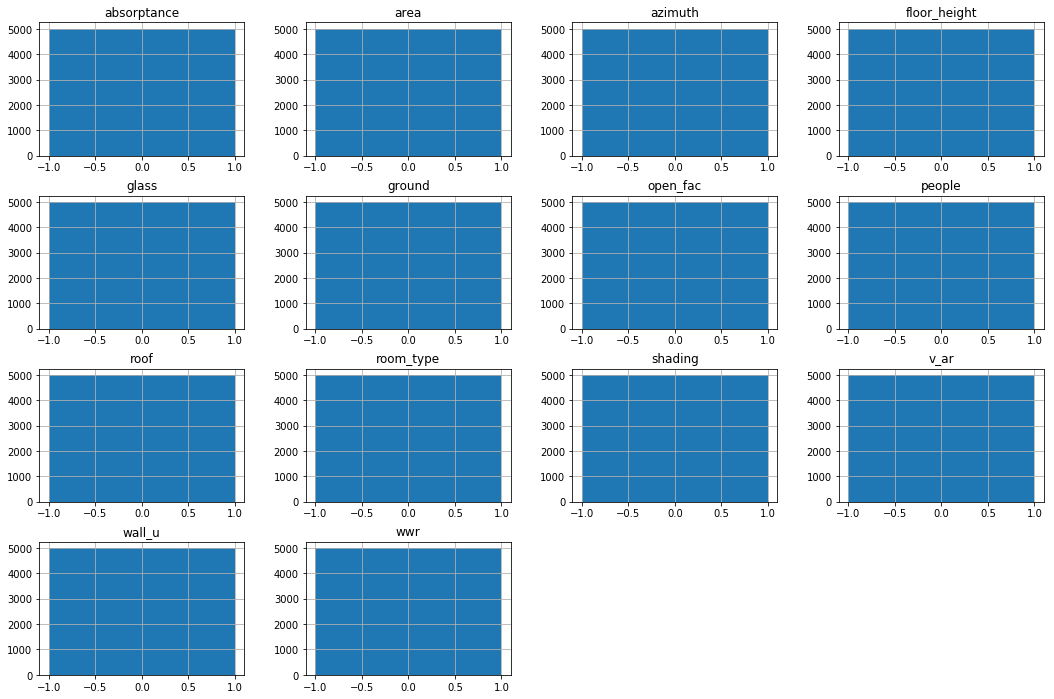

In [0]:
# Check features' histograms.

_ = dataset_features.hist(bins=20, figsize=(18, 12), xlabelsize=10)

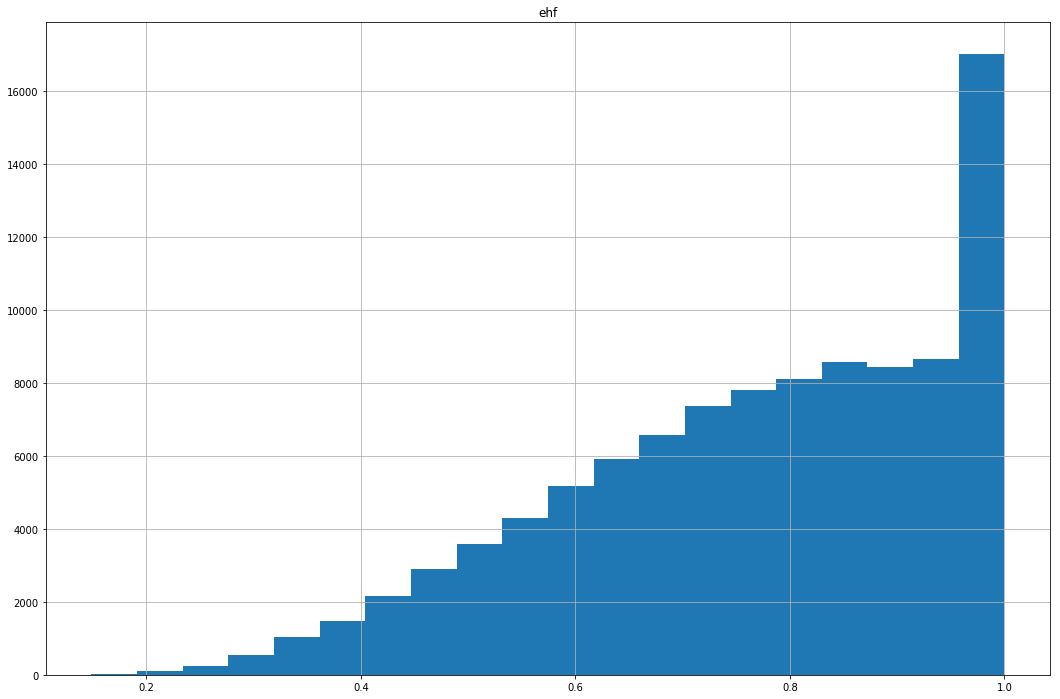

In [0]:
# Check targets' histogram.

_ = dataset_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [0]:
# Functions to normalize the data.
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

def log_normalize(series, base = 10):
  return series.apply(lambda x:math.log(x+1.0, base))

def inv_log_normalize(series, base = 10):
  return series.apply(lambda x:math.log(1/(x+1.0), base))

def pow_normalize(series, base=1/2):
  return series.apply(lambda x:math.pow(x, base))

def sigmoid_normalize(series):
  return series.apply(lambda x:1/(1+math.exp(-x)))

def tan_normalize(series):
  return series.apply(lambda x:math.tan(x))

def asinh_normalize(series):
  return series.apply(lambda x:math.asinh(x))

def atan_normalize(series):
  return series.apply(lambda x:math.atan(x))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in range(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]


In [0]:
# Normalize tergets using log funcition
# check_targets_distribution = pow_normalize(dataset_targets[target], base=5)
# _ =  check_targets_distribution.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [0]:
# dataset_features['roof'] = binary_threshold(dataset_features['roof'], .6)  # 0)
# dataset_features['ground'] = binary_threshold(dataset_features['ground'], .7)  # 0)

# # room_type from num to factor
# string_roomtype = dataset_features['room_type'].apply(lambda x: '0_window')
# string_roomtype[dataset_features['room_type'] < .6] = '3_wall'
# string_roomtype[dataset_features['room_type'] < .2] = '1_wall'
# string_roomtype[dataset_features['room_type'] < -.2] = '3_window'
# string_roomtype[dataset_features['room_type'] < -.6] = '1_window'
# dataset_features['room_type'] = string_roomtype

# # v_ar to discrete
# string_v_ar = dataset_features['v_ar'].apply(lambda x: .5)  
# string_v_ar[dataset_features['v_ar'] < .5] = 0
# string_v_ar[dataset_features['v_ar'] < 0] = -.5
# string_v_ar[dataset_features['v_ar'] < -.5] = -1
# dataset_features['v_ar'] = string_v_ar

# #validation
# dataset_validation_features['roof'] = binary_threshold(dataset_validation_features['roof'], .6)  # 0)
# dataset_validation_features['ground'] = binary_threshold(dataset_validation_features['ground'], .7)  # 0)

# # room_type from num to factor
# string_roomtype = dataset_validation_features['room_type'].apply(lambda x: '0_window')  
# string_roomtype[dataset_validation_features['room_type'] < .6] = '3_wall'
# string_roomtype[dataset_validation_features['room_type'] < .2] = '1_wall'
# string_roomtype[dataset_validation_features['room_type'] < -.2] = '3_window'
# string_roomtype[dataset_validation_features['room_type'] < -.6] = '1_window'
# dataset_validation_features['room_type'] = string_roomtype

# # v_ar to discrete
# string_v_ar = dataset_validation_features['v_ar'].apply(lambda x: .5)  
# string_v_ar[dataset_validation_features['v_ar'] < .5] = 0
# string_v_ar[dataset_validation_features['v_ar'] < 0] = -.5
# string_v_ar[dataset_validation_features['v_ar'] < -.5] = -1
# dataset_validation_features['v_ar'] = string_v_ar

#test
dataset_test_features['roof'] = binary_threshold(dataset_test_features['roof'], .6)  # 0)
dataset_test_features['ground'] = binary_threshold(dataset_test_features['ground'], .7)  # 0)

# room_type from num to factor
string_roomtype = dataset_test_features['room_type'].apply(lambda x: '0_window')  
string_roomtype[dataset_test_features['room_type'] < .6] = '3_wall'
string_roomtype[dataset_test_features['room_type'] < .2] = '1_wall'
string_roomtype[dataset_test_features['room_type'] < -.2] = '3_window'
string_roomtype[dataset_test_features['room_type'] < -.6] = '1_window'
dataset_test_features['room_type'] = string_roomtype

# v_ar to discrete
string_v_ar = dataset_test_features['v_ar'].apply(lambda x: .5)  
string_v_ar[dataset_test_features['v_ar'] < .5] = 0
string_v_ar[dataset_test_features['v_ar'] < 0] = -.5
string_v_ar[dataset_test_features['v_ar'] < -.5] = -1
dataset_test_features['v_ar'] = string_v_ar

In [0]:
# SKIP!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# dataset = dataset.drop(dataset[dataset['temp'] > 40].index)

dataset_features['area_real'] = dataset_features['area'].apply(lambda x: 60 + x*40)
dataset_features['ratio_real'] = dataset_features['ratio'].apply(lambda x: 1.25 + x*.75)
dataset_features['zone_height_real'] = dataset_features['zone_height'].apply(lambda x: 2.8 + x*.4)
dataset_features['wwr_real'] = dataset_features['wwr'].apply(lambda x: .35 + x*.25)

dataset_features['wall_0'] = (dataset_features['area_real']/dataset_features['ratio_real'])**(1/2) * dataset_features['zone_height_real']
dataset_features['wall_2'] = 0  # dataset_features['wall_0']
dataset_features['wall_1'] = dataset_features['wall_0'] * dataset_features['ratio_real']
dataset_features['wall_3'] = dataset_features['wall_1']

dataset_features.loc[dataset_features['room_type'] == '0_window', 'wall_3'] = 0
dataset_features.loc[dataset_features['room_type'] == '0_window', 'wall_1'] = 0
dataset_features.loc[(dataset_features['room_type'] == '1_wall') | (dataset_features['room_type'] == '1_window'), 'wall_3'] = 0
dataset_features.loc[(dataset_features['room_type'] == '3_wall') | (dataset_features['room_type'] == '3_window'), 'wall_1'] = 0

# dataset_features['wwr_0'] = 0
dataset_features['wwr_1'] = 0
dataset_features['wwr_2'] = 0
dataset_features['wwr_3'] = 0

dataset_features['wwr_0'] = dataset_features['wwr_real']
dataset_features.loc[dataset_features['room_type'] == '1_window', 'wwr_1'] = dataset_features['wwr_real']
dataset_features.loc[dataset_features['room_type'] == '3_window', 'wwr_3'] = dataset_features['wwr_real']

max_wall_area = 45
dataset_features['wall_0'] = dataset_features['wall_0']/max_wall_area
dataset_features['wall_2'] = dataset_features['wall_2']/max_wall_area
dataset_features['wall_1'] = dataset_features['wall_1']/max_wall_area
dataset_features['wall_3'] = dataset_features['wall_3']/max_wall_area

In [0]:
# dataset_targets[target] = pow_normalize(dataset_targets[target], base=5)

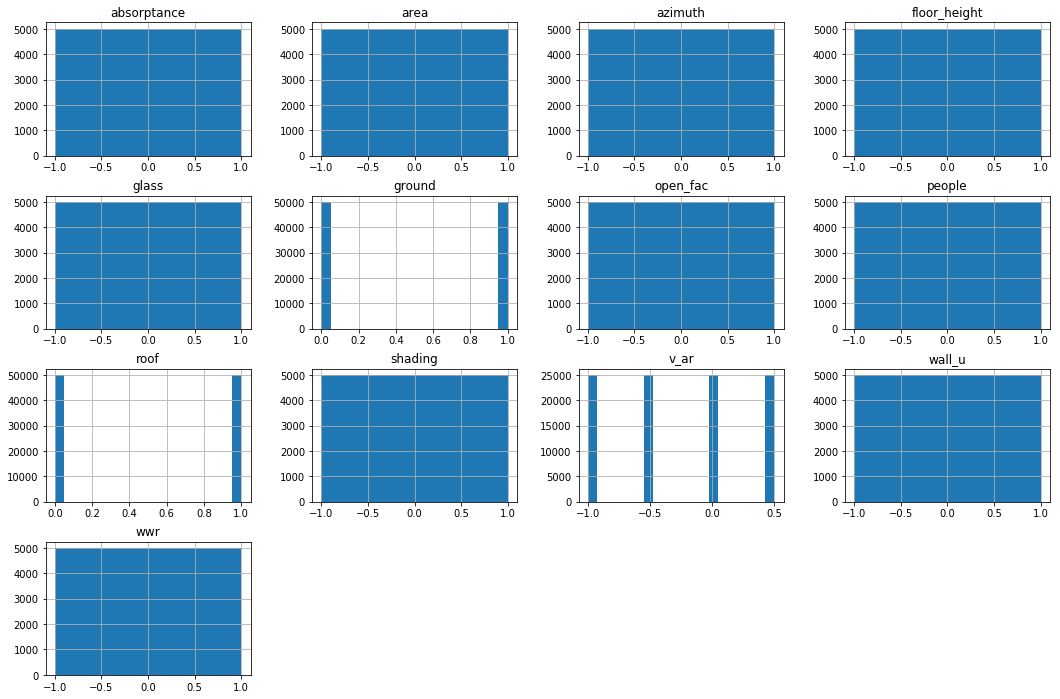

In [0]:
# Check features' histograms.

_ = dataset_features.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [0]:
print(
    dataset_features['wall_0'].max(),
    dataset_features['wall_2'].max(),
    dataset_features['wall_1'].max(),
    dataset_features['wall_3'].max(),

    dataset_features['wwr_0'].max(),
    dataset_features['wwr_1'].max(),
    dataset_features['wwr_2'].max(),
    dataset_features['wwr_3'].max()
)

In [0]:
# SKIP!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

cond_N = (dataset_features['azimuth'] < -.75) | (dataset_features['azimuth'] > .75)
cond_E = (dataset_features['azimuth'] < -.25) & (dataset_features['azimuth'] > -.75)
cond_S = (dataset_features['azimuth'] < .25) & (dataset_features['azimuth'] > -.25)
cond_W = (dataset_features['azimuth'] < .75) & (dataset_features['azimuth'] > .25)
wall_1exp = (dataset_features['room_type'] == '1_wall')
wall_3exp = (dataset_features['room_type'] == '3_wall')
window_1exp = (dataset_features['room_type'] == '1_window')
window_3exp = (dataset_features['room_type'] == '3_window')

dataset_features['wall_N'] = dataset_features['wall_0'].where(cond_N, 0)
dataset_features['wall_E'] = dataset_features['wall_0'].where(cond_E, 0)
dataset_features['wall_S'] = dataset_features['wall_0'].where(cond_S, 0)
dataset_features['wall_W'] = dataset_features['wall_0'].where(cond_W, 0)

dataset_features['wall_N'] = dataset_features['wall_1'].where((cond_W & (wall_1exp | window_1exp)), dataset_features['wall_N'])
dataset_features['wall_E'] = dataset_features['wall_1'].where((cond_N & (wall_1exp | window_1exp)), dataset_features['wall_E'])
dataset_features['wall_S'] = dataset_features['wall_1'].where((cond_E & (wall_1exp | window_1exp)), dataset_features['wall_S'])
dataset_features['wall_W'] = dataset_features['wall_1'].where((cond_S & (wall_1exp | window_1exp)), dataset_features['wall_W'])

dataset_features['wall_N'] = dataset_features['wall_3'].where((cond_E & (wall_3exp | window_3exp)), dataset_features['wall_N'])
dataset_features['wall_E'] = dataset_features['wall_3'].where((cond_S & (wall_3exp | window_3exp)), dataset_features['wall_E'])
dataset_features['wall_S'] = dataset_features['wall_3'].where((cond_W & (wall_3exp | window_3exp)), dataset_features['wall_S'])
dataset_features['wall_W'] = dataset_features['wall_3'].where((cond_N & (wall_3exp | window_3exp)), dataset_features['wall_W'])

dataset_features['wwr_N'] = dataset_features['wwr_real'].where(dataset_features['wall_N'] > 0, 0)
dataset_features['wwr_E'] = dataset_features['wwr_real'].where(dataset_features['wall_E'] > 0, 0)
dataset_features['wwr_S'] = dataset_features['wwr_real'].where(dataset_features['wall_S'] > 0, 0)
dataset_features['wwr_W'] = dataset_features['wwr_real'].where(dataset_features['wall_W'] > 0, 0)

dataset_features[['azimuth', 'room_type', 'wall_N', 'wall_E', 'wall_S', 'wall_W', 'wwr_N', 'wwr_E', 'wwr_S', 'wwr_W', 'wall_0', 'wall_1', 'wall_3', 'wall_2']].head(10)

                                                          

## Training Dataset

In [0]:
# SKIP!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

dataset_validation['roof'] = binary_threshold(dataset_validation['roof'], 0)
dataset_validation['ground'] = binary_threshold(dataset_validation['ground'], 0)

string_roomtype = dataset_validation['room_type'].apply(lambda x: '0_window')
  
string_roomtype[dataset_validation['room_type'] < .6] = '3_wall'
string_roomtype[dataset_validation['room_type'] < .2] = '1_wall'
string_roomtype[dataset_validation['room_type'] < -.2] = '3_window'
string_roomtype[dataset_validation['room_type'] < -.6] = '1_window'

dataset_validation['room_type'] = string_roomtype

# dataset = dataset.drop(dataset[dataset['temp'] > 40].index)

# dataset_validation['area_real'] = dataset_validation['area'].apply(lambda x: 60 + x*40)
# dataset_validation['ratio_real'] = dataset_validation['ratio'].apply(lambda x: 1.25 + x*.75)
# dataset_validation['zone_height_real'] = dataset_validation['zone_height'].apply(lambda x: 2.8 + x*.4)
# dataset_validation['wwr_real'] = dataset_validation['wwr'].apply(lambda x: .35 + x*.25)

# dataset_validation['wall_0'] = (dataset_validation['area_real']/dataset_validation['ratio_real'])**(1/2) * dataset_validation['zone_height_real']
# dataset_validation['wall_2'] = 0  # dataset_validation['wall_0']
# dataset_validation['wall_1'] = dataset_validation['wall_0'] * dataset_validation['ratio_real']
# dataset_validation['wall_3'] = dataset_validation['wall_1']

# dataset_validation.loc[dataset_validation['room_type'] == '0_window', 'wall_3'] = 0
# dataset_validation.loc[dataset_validation['room_type'] == '0_window', 'wall_1'] = 0
# dataset_validation.loc[(dataset_validation['room_type'] == '1_wall') | (dataset_validation['room_type'] == '1_window'), 'wall_3'] = 0
# dataset_validation.loc[(dataset_validation['room_type'] == '3_wall') | (dataset_validation['room_type'] == '3_window'), 'wall_1'] = 0

# # dataset_validation['wwr_0'] = 0
# dataset_validation['wwr_1'] = 0
# dataset_validation['wwr_2'] = 0
# dataset_validation['wwr_3'] = 0

# dataset_validation['wwr_0'] = dataset_validation['wwr_real']
# dataset_validation.loc[dataset_validation['room_type'] == '1_window', 'wwr_1'] = dataset_validation['wwr_real']
# dataset_validation.loc[dataset_validation['room_type'] == '3_window', 'wwr_3'] = dataset_validation['wwr_real']

# max_wall_area = 45
# dataset_validation['wall_0'] = dataset_validation['wall_0']/max_wall_area
# dataset_validation['wall_2'] = dataset_validation['wall_2']/max_wall_area
# dataset_validation['wall_1'] = dataset_validation['wall_1']/max_wall_area
# dataset_validation['wall_3'] = dataset_validation['wall_3']/max_wall_area

# cond_N = (dataset_validation['azimuth'] < -.75) | (dataset_validation['azimuth'] > .75)
# cond_E = (dataset_validation['azimuth'] < -.25) & (dataset_validation['azimuth'] > -.75)
# cond_S = (dataset_validation['azimuth'] < .25) & (dataset_validation['azimuth'] > -.25)
# cond_W = (dataset_validation['azimuth'] < .75) & (dataset_validation['azimuth'] > .25)
# wall_1exp = (dataset_validation['room_type'] == '1_wall')
# wall_3exp = (dataset_validation['room_type'] == '3_wall')
# window_1exp = (dataset_validation['room_type'] == '1_window')
# window_3exp = (dataset_validation['room_type'] == '3_window')

# dataset_validation['wall_N'] = dataset_validation['wall_0'].where(cond_N, 0)
# dataset_validation['wall_E'] = dataset_validation['wall_0'].where(cond_E, 0)
# dataset_validation['wall_S'] = dataset_validation['wall_0'].where(cond_S, 0)
# dataset_validation['wall_W'] = dataset_validation['wall_0'].where(cond_W, 0)

# dataset_validation['wall_N'] = dataset_validation['wall_1'].where((cond_W & (wall_1exp | window_1exp)), dataset_validation['wall_N'])
# dataset_validation['wall_E'] = dataset_validation['wall_1'].where((cond_N & (wall_1exp | window_1exp)), dataset_validation['wall_E'])
# dataset_validation['wall_S'] = dataset_validation['wall_1'].where((cond_E & (wall_1exp | window_1exp)), dataset_validation['wall_S'])
# dataset_validation['wall_W'] = dataset_validation['wall_1'].where((cond_S & (wall_1exp | window_1exp)), dataset_validation['wall_W'])

# dataset_validation['wall_N'] = dataset_validation['wall_3'].where((cond_E & (wall_3exp | window_3exp)), dataset_validation['wall_N'])
# dataset_validation['wall_E'] = dataset_validation['wall_3'].where((cond_S & (wall_3exp | window_3exp)), dataset_validation['wall_E'])
# dataset_validation['wall_S'] = dataset_validation['wall_3'].where((cond_W & (wall_3exp | window_3exp)), dataset_validation['wall_S'])
# dataset_validation['wall_W'] = dataset_validation['wall_3'].where((cond_N & (wall_3exp | window_3exp)), dataset_validation['wall_W'])

# dataset_validation['wwr_N'] = dataset_validation['wwr_real'].where(dataset_validation['wall_N'] > 0, 0)
# dataset_validation['wwr_E'] = dataset_validation['wwr_real'].where(dataset_validation['wall_E'] > 0, 0)
# dataset_validation['wwr_S'] = dataset_validation['wwr_real'].where(dataset_validation['wall_S'] > 0, 0)
# dataset_validation['wwr_W'] = dataset_validation['wwr_real'].where(dataset_validation['wall_W'] > 0, 0)

# dataset_validation[['azimuth', 'room_type', 'wall_N', 'wall_E', 'wall_S', 'wall_W', 'wwr_N', 'wwr_E', 'wwr_S', 'wwr_W', 'wall_0', 'wall_1', 'wall_3', 'wall_2']].head(10)

                                                          

## 5. Separação dos dados para treinamento e teste

In [0]:
# # Define the size of training and validation.
# training_fraction = .75

# training_size = int(len(dataset_features.index)*training_fraction)
# validation_size = len(dataset_features.index)-training_size

# # Choose the first examples for training.
# training_examples = dataset_features.head(training_size)
# training_targets = dataset_targets.head(training_size)

# # Choose the last examples for validation.
# validation_examples = dataset_features.tail(validation_size)
# validation_targets = dataset_targets.tail(validation_size)

# # examples for training.
# training_examples = dataset_features
# training_targets = dataset_targets

# # examples for validation.
# validation_examples = dataset_validation_features  # preprocess_features(dataset_validation,features)
# validation_targets = dataset_validation_targets  # preprocess_targets(dataset_validation,target)

# examples for test.
test_examples = dataset_test_features  
test_targets = dataset_test_targets  

# # Double-check that we've done the right thing.
# print("Training examples summary:")
# display.display(training_examples.describe())
# print("Validation examples summary:")
# display.display(validation_examples.describe())

# print("Training targets summary:")
# display.display(training_targets.describe())
# print("Validation targets summary:")
# display.display(validation_targets.describe())


print("Test examples summary:")
display.display(test_examples.describe())

print("Validation targets summary:")
display.display(test_targets.describe())


Test examples summary:


,area,azimuth,floor_height,absorptance,wall_u,wwr,shading,people,open_fac,roof,ground,v_ar,glass
count,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.20,0.15,-0.25,-0.00
std,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.40,0.36,0.56,0.58
min,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,-1.00,-1.00
25%,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,0.00,0.00,-0.62,-0.50
50%,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.25,-0.00
75%,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.00,0.00,0.12,0.50
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,1.00


Validation targets summary:


,ehf
count,20000.00
mean,0.76
std,0.19
min,0.00
25%,0.63
50%,0.78
75%,0.91
max,1.00


## 6. Treinando a RNA

In [0]:
# ['area', 'azimuth', 'floor_height', 'absorptance', 'wall_u', 'wwr', 
# 'shading', 'people', 'open_fac', 'roof', 'ground', 'v_ar', 'room_type']

def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  
  area = tf.feature_column.numeric_column("area")
  azimuth = tf.feature_column.numeric_column("azimuth")
  floor_height = tf.feature_column.numeric_column("floor_height")
  absorptance = tf.feature_column.numeric_column("absorptance")
  shading = tf.feature_column.numeric_column("shading")
  wall_u = tf.feature_column.numeric_column("wall_u")
#   wall_ct = tf.feature_column.numeric_column("wall_ct")
  wwr = tf.feature_column.numeric_column("wwr")
  glass = tf.feature_column.numeric_column("glass")
#   wall_N =  tf.feature_column.numeric_column('wall_N')
#   wall_E =  tf.feature_column.numeric_column('wall_E')
#   wall_S =  tf.feature_column.numeric_column('wall_S')
#   wall_W =  tf.feature_column.numeric_column('wall_W')
#   wwr_N =  tf.feature_column.numeric_column('wwr_N')
#   wwr_E =  tf.feature_column.numeric_column('wwr_E')
#   wwr_S =  tf.feature_column.numeric_column('wwr_S')
#   wwr_W =  tf.feature_column.numeric_column('wwr_W')
  open_fac = tf.feature_column.numeric_column("open_fac")
  people = tf.feature_column.numeric_column("people")
  ground = tf.feature_column.numeric_column("ground")
  roof = tf.feature_column.numeric_column("roof")
  v_ar = tf.feature_column.numeric_column("v_ar")
  
  terms = ('0_window', '3_wall', '1_wall', '3_window', '1_window')
  room_type = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key="room_type", vocabulary_list=terms))

  return set([area,
              azimuth,
              floor_height,
              absorptance,
              shading,
              wall_u,
#               wall_ct,
              wwr,
              glass,
#               wall_N,
#               wall_E,
#               wall_S,
#               wall_W,
#               wwr_N,
#               wwr_E,
#               wwr_S,
#               wwr_W,
              open_fac,
              people,
              ground,
              roof,
              v_ar,
              room_type
             ])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    target,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    periods = 10):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      the dataset to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      the dataset to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      the dataset to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      the dataset to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      model_dir='ann'
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets[target], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets[target], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[target], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.4f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.4f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.4f" % validation_root_mean_squared_error)

  return dnn_regressor #, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.0184
  period 01 : 0.0160
  period 02 : 0.0145
  period 03 : 0.0138
  period 04 : 0.0136
  period 05 : 0.0134
  period 06 : 0.0133
  period 07 : 0.0130
  period 08 : 0.0133
  period 09 : 0.0128
Model training finished.
Final RMSE (on training data):   0.0128
Final RMSE (on validation data): 0.0130


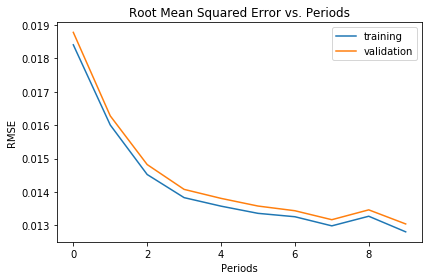

In [0]:
EHF = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05), # AdagradOptimizer
    steps=150000,
    batch_size=50,
    hidden_units=[50, 20], # duas camadas
    target=target,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


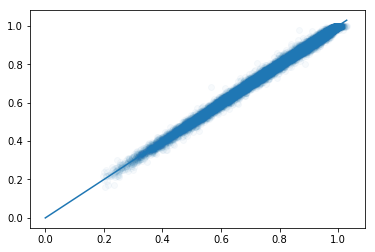

In [0]:

predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets[target], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = EHF.predict(input_fn=predict_validation_input_fn)
# validation_predictions = classifier.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

d = {'pred': validation_predictions, 'simulado': validation_targets[target]}
plot_df = pd.DataFrame(data = d)

# plot_df['pred'] = plot_df['pred'].apply(lambda x: 0 if x < 0 else x)
# plot_df['pred'] = plot_df['pred'].apply(lambda x: math.pow(x, 1/5))
# plot_df['real'] = plot_df['real'].apply(lambda x: math.pow(x, 1/5))

plt.plot([0,max(plot_df['pred'].max(),plot_df['simulado'].max())],[0,max(plot_df['pred'].max(),plot_df['simulado'].max())])

plt.scatter(plot_df['pred'], plot_df['simulado'], alpha = .03)

plot_df.to_csv('ann_validation_'+datetime.today().strftime('%m-%d')+'.csv')


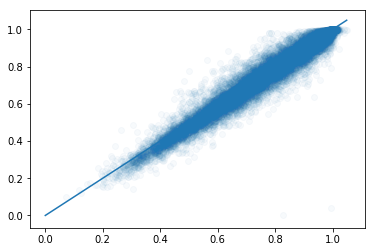

In [0]:
predict_test_input_fn = lambda: my_input_fn(test_examples, 
                                                  test_targets[target], 
                                                  num_epochs=1, 
                                                  shuffle=False)

test_predictions = EHF.predict(input_fn=predict_test_input_fn)
# validation_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

d = {'pred': test_predictions, 'simulado': test_targets[target]}
plot_df = pd.DataFrame(data = d)

# plot_df['pred'] = plot_df['pred'].apply(lambda x: 0 if x < 0 else x)
# plot_df['pred'] = plot_df['pred'].apply(lambda x: math.pow(x, 1/5))
# plot_df['real'] = plot_df['real'].apply(lambda x: math.pow(x, 1/5))

plt.plot([0,max(plot_df['pred'].max(),plot_df['simulado'].max())],[0,max(plot_df['pred'].max(),plot_df['simulado'].max())])

plt.scatter(plot_df['pred'], plot_df['simulado'], alpha = .03)

plot_df.to_csv('ann_test_'+datetime.today().strftime('%m-%d')+'.csv')

In [0]:
EHF2 = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05), # AdagradOptimizer
    steps= 50000,
    batch_size=50,
    hidden_units=[50, 50, 20], # tres camadas
    target=target,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [0]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets[target], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = EHF2.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

d = {'pred': validation_predictions, 'real': validation_targets[target]}
plot_df = pd.DataFrame(data = d)
# plot_df['pred'] = plot_df['pred'].apply(lambda x: 0 if x < 0 else x)
# plot_df['pred'] = plot_df['pred'].apply(lambda x: math.pow(x, 1/5))
# plot_df['real'] = plot_df['real'].apply(lambda x: math.pow(x, 1/5))

plt.plot([0,max(plot_df['pred'].max(),plot_df['real'].max())],[0,max(plot_df['pred'].max(),plot_df['real'].max())])

plt.scatter(plot_df['pred'], plot_df['real'], alpha = .03)

In [0]:
validation_diff = validation_predictions-validation_targets

print(percentile(validation_diff,.95))
print(percentile(validation_diff,.05))

## Extra

In [0]:
from google.colab import files


In [0]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets[target], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = EHF.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

d = {'pred': validation_predictions, 'simulado': validation_targets[target]}
plot_df_test = pd.DataFrame(data = d)

plot_df_test.to_csv('plot_test_08-06.csv')
# files.download('plot_test_04-24.csv')


In [0]:
# mv /content/model.ckpt-150000\(3\).index /content/model.ckpt-150000.index

# mv /content/model.ckpt-150000\(3\).meta /content/model.ckpt-150000.meta


In [0]:
!zip -r /content/ann.zip /content/ann

  adding: content/ann/ (stored 0%)
  adding: content/ann/model.ckpt-105000.index (deflated 42%)
  adding: content/ann/model.ckpt-90000.meta (deflated 34%)
  adding: content/ann/model.ckpt-90000.index (deflated 42%)
  adding: content/ann/model.ckpt-150000.data-00001-of-00002 (deflated 5%)
  adding: content/ann/events.out.tfevents.1565790936.6a710ffacedc (deflated 35%)
  adding: content/ann/model.ckpt-135000.data-00000-of-00002 (deflated 13%)
  adding: content/ann/model.ckpt-150000.meta (deflated 34%)
  adding: content/ann/model.ckpt-90000.data-00001-of-00002 (deflated 5%)
  adding: content/ann/model.ckpt-120000.data-00000-of-00002 (deflated 13%)
  adding: content/ann/checkpoint (deflated 76%)
  adding: content/ann/model.ckpt-90000.data-00000-of-00002 (deflated 13%)
  adding: content/ann/model.ckpt-105000.meta (deflated 34%)
  adding: content/ann/model.ckpt-135000.data-00001-of-00002 (deflated 5%)
  adding: content/ann/graph.pbtxt (deflated 72%)
  adding: content/ann/model.ckpt-135000.me

In [0]:
from google.colab import files
files.download("/content/ann.zip")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 38914, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
# !unzip ann.zip 
!mv content/ann .

In [0]:
EHF = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(),
      hidden_units=[50,20],
      model_dir='ann'
      )


### To Do List:

- ;

